# Convolutional Neural Networks (CNNs) with PyTorch — MNIST Tutorial

**Contents**
0. Prerequisites & setup
1. The convolution operation (intuition + formulas)
2. Dataset (MNIST) and `DataLoader`
3. Building a CNN (detailed architecture and explanations)
4. Training loop, validation, scheduler, and checkpointing
5. Saving & loading models; inference
6. Visualizing filters and feature maps

## 0) Prerequisites

Run the following if you don't already have the required packages:

```bash
# Optional: install PyTorch (pick appropriate command for your system)
# pip install torch torchvision torchaudio
# pip install matplotlib tqdm
```

This notebook uses:
- `torch`, `torchvision` (PyTorch) for model, training and datasets
- `numpy` and `matplotlib` for visualization
- `tqdm` for progress bars (optional)

In [1]:
# Imports, reproducibility, and device selection
import os, random, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 1) The convolution operation — intuition & formulas

A 2D discrete convolution between an input image (or feature map) $X$ and a kernel (filter) $K$ produces an output feature map $Y$:
\begin{align*}
Y(i, j) = \sum_{u=0}^{k_h-1}\sum_{v=0}^{k_w-1} K(u,v)\, X(i+u, j+v)
\end{align*}

In practice we also use **stride** $s$ and **padding** $p$. For a square input of spatial size $W \times H$ and a square kernel of size $K \times K$, the output spatial size $W_{\text{out}} \times H_{\text{out}}$ is:
\begin{align*}
W_{\text{out}} &= \left\lfloor \frac{W - K + 2p}{s} \right\rfloor + 1, \\[4pt]
H_{\text{out}} &= \left\lfloor \frac{H - K + 2p}{s} \right\rfloor + 1.
\end{align*}

Key concepts:
- **Channels:** images have channels (e.g., 1 for grayscale, 3 for RGB). A conv layer uses multiple kernels to produce multiple output channels.
- **Receptive field:** how many input pixels affect a given output; deeper layers increase receptive field.
- **Padding types:** `valid` (no padding), `same` (pad so output size equals input size for stride 1).
- **Pooling:** reduces spatial size (e.g., `MaxPool2d`) and increases translational invariance.

We'll use these formulas when designing networks to check dimensionality by hand and with helper functions.


## 2) Dataset: MNIST and DataLoaders

We will use the classic MNIST dataset (grayscale 28×28 handwritten digits). Standard normalization values for MNIST are `mean=0.1307` and `std=0.3081` (computed over the training set).

We'll prepare train / validation / test splits, apply standard transforms, and use `DataLoader` for batching.


In [ ]:
# Data transforms and loaders for MNIST
DATA_DIR = './mnist_data'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

batch_size = 128
num_workers = 2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean, std for MNIST
])

# Download datasets (train includes train set; we'll split it)
train_val = datasets.MNIST(DATA_DIR, train=True, download=True, transform=transform)
test_set = datasets.MNIST(DATA_DIR, train=False, download=True, transform=transform)

# Train/validation split (e.g., 90% train, 10% val)
val_frac = 0.1
n_train = len(train_val)
n_val = int(n_train * val_frac)
n_train_new = n_train - n_val
train_set, val_set = torch.utils.data.random_split(train_val, [n_train_new, n_val], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f'Train samples: {len(train_set)}, Val samples: {len(val_set)}, Test samples: {len(test_set)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]

Train samples: 54000, Val samples: 6000, Test samples: 10000


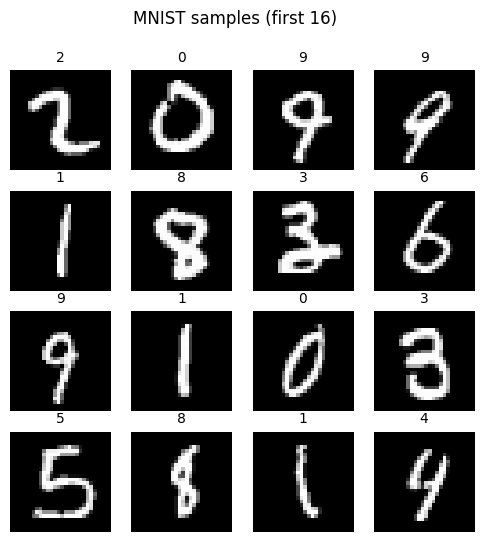

In [3]:
# Visualize some MNIST samples (unnormalized for display)
def imshow(img, ax=None, cmap='gray'):
    if ax is None: ax = plt.gca()
    img = img.squeeze(0)  # (1,H,W) -> (H,W)
    ax.imshow(img, cmap=cmap)
    ax.axis('off')

# Get a batch
images, labels = next(iter(train_loader))
# Unnormalize for display
imgs = images[:16] * 0.3081 + 0.1307
labels = labels[:16]

fig, axes = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    imshow(imgs[i], ax=ax)
    ax.set_title(int(labels[i].item()), fontsize=10)
plt.suptitle('MNIST samples (first 16)')
plt.show()

## 3) CNN Model — definition and explanation

Below we define a compact CNN for MNIST. The architecture is intentionally simple but realistic:
- Two convolutional blocks (Conv -> BatchNorm -> ReLU -> MaxPool)
- A small fully-connected classifier head
- Dropout for regularization

We'll comment each part to make the purpose clear.


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        # First convolutional block: output channels 16, kernel 3, padding 1 keeps spatial size when stride=1
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(16)
        # Second block: increase channels, reduce spatial size via MaxPool
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28 (before pool)
        self.bn2 = nn.BatchNorm2d(32)
        # Pooling halves spatial dims: 28 -> 14
        self.pool = nn.MaxPool2d(2, 2)
        # After two blocks we'll have 32 channels and spatial 14x14, we can add another pool to reduce more
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.bn3 = nn.BatchNorm2d(64)
        # final pooling to 7x7
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # 28 -> 14
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # 14 -> 7
        # Block 3 (feature increase)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        # At this point spatial dims should be 7x7
        # Flatten
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move to device
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Computing spatial dimensions step-by-step

Use the formula introduced earlier to verify spatial dimensions after each layer. The helper below runs a dummy tensor through the model and prints shapes so you can verify channels and spatial sizes at each stage.


In [6]:
# Helper to print shapes through the network
def print_layer_shapes(model, input_size=(1,28,28)):
    x = torch.zeros((1,) + input_size).to(device)  # batch size 1, move to device
    hooks = []
    shapes = []
    def hook(module, inp, out):
        shapes.append((module.__class__.__name__, tuple(out.shape)))
    for name, module in model.named_modules():
        # attach hook to layers that produce output tensors we want to inspect
        if isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.BatchNorm2d, nn.Linear)):
            hooks.append(module.register_forward_hook(hook))
    model.eval()
    with torch.no_grad():
        model(x) # use the tensor moved to device
    for h in hooks:
        h.remove()
    for clsname, shape in shapes:
        print(f'{clsname:15s} -> {shape}')

print_layer_shapes(model, input_size=(1,28,28))

Conv2d          -> (1, 16, 28, 28)
BatchNorm2d     -> (1, 16, 28, 28)
MaxPool2d       -> (1, 16, 14, 14)
Conv2d          -> (1, 32, 14, 14)
BatchNorm2d     -> (1, 32, 14, 14)
MaxPool2d       -> (1, 32, 7, 7)
Conv2d          -> (1, 64, 7, 7)
BatchNorm2d     -> (1, 64, 7, 7)
Linear          -> (1, 128)
Linear          -> (1, 10)


## 4) Training loop, validation, scheduler, and checkpointing

We'll define:
- an optimizer (Adam), a learning-rate scheduler, and a standard training loop with validation per epoch;
- checkpoint saving (best model by validation accuracy) and optional resume from checkpoint;

The training loop is written to be clear and easy to adapt for other datasets or models.


In [7]:
# Training utilities
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return np.mean(losses), correct/total

def train(model, train_loader, val_loader, device, epochs=10, lr=1e-3, save_path='cnn_checkpoint.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for x,y in tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step(val_loss)
        print(f'Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
        # checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'val_acc': val_acc}, save_path)
            print(f'  Saved new best model (val_acc={val_acc:.4f}) to {save_path}')
    return history

# Run training (small number of epochs for demo)
history = train(model, train_loader, val_loader, device, epochs=6, lr=1e-3, save_path='./mnist_data/cnn_mnist_best.pth')

Epoch 1/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 1: train_loss=0.1230, val_loss=0.0586, val_acc=0.9830
  Saved new best model (val_acc=0.9830) to ./mnist_data/cnn_mnist_best.pth


Epoch 2/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 2: train_loss=0.0468, val_loss=0.0548, val_acc=0.9840
  Saved new best model (val_acc=0.9840) to ./mnist_data/cnn_mnist_best.pth


Epoch 3/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0339, val_loss=0.0464, val_acc=0.9862
  Saved new best model (val_acc=0.9862) to ./mnist_data/cnn_mnist_best.pth


Epoch 4/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 4: train_loss=0.0272, val_loss=0.0414, val_acc=0.9880
  Saved new best model (val_acc=0.9880) to ./mnist_data/cnn_mnist_best.pth


Epoch 5/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0218, val_loss=0.0456, val_acc=0.9870


Epoch 6/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0206, val_loss=0.0368, val_acc=0.9883
  Saved new best model (val_acc=0.9883) to ./mnist_data/cnn_mnist_best.pth


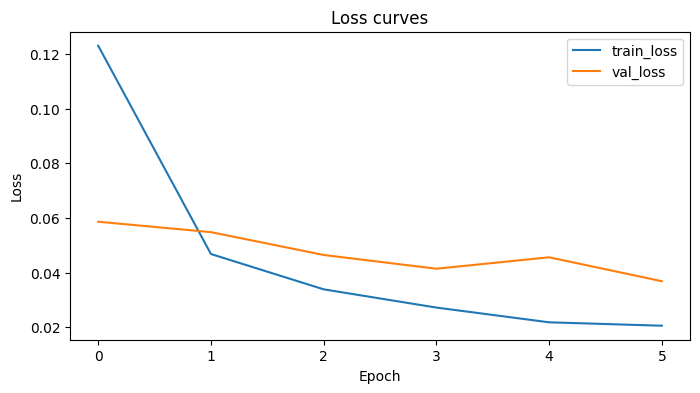

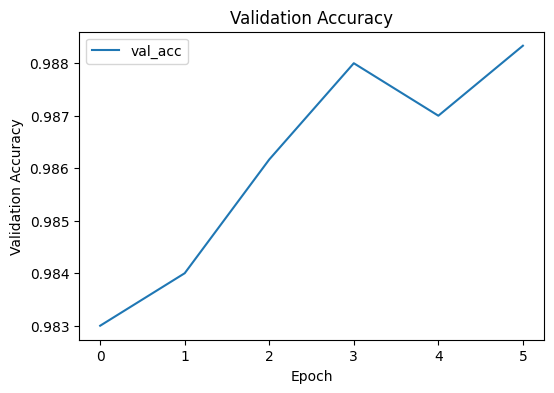

In [8]:
# Plot training/validation curves
plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss curves')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy'); plt.legend(); plt.title('Validation Accuracy')
plt.show()

In [9]:
# Load best checkpoint and evaluate on test set
ckpt_path = './mnist_data/cnn_mnist_best.pth'
if Path(ckpt_path).exists():
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    print('Loaded checkpoint from epoch', ckpt.get('epoch'), 'val_acc', ckpt.get('val_acc'))
else:
    print('No checkpoint found at', ckpt_path)

test_loss, test_acc = evaluate(model, test_loader, device)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

Loaded checkpoint from epoch 6 val_acc 0.9883333333333333
Test loss: 0.0304, Test acc: 0.9903


## 5) Saving / Loading and Inference

- We save a checkpoint dictionary containing epoch, `model_state` and `optimizer_state`. Use `torch.save(...)` and `torch.load(...)`.  
- For inference, set `model.eval()` to disable dropout and use running statistics in BatchNorm. Move inputs to the same device as the model.


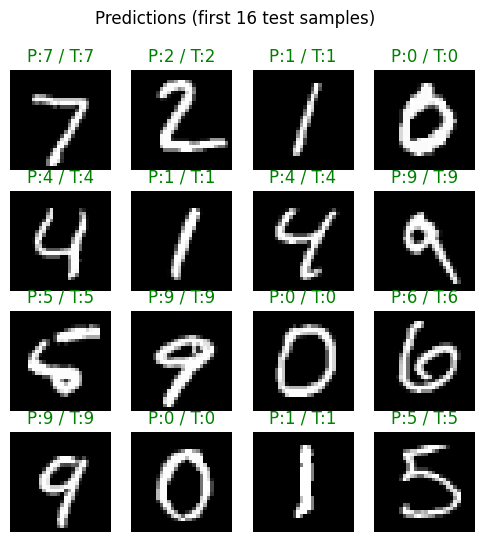

In [10]:
# Example: predict a few samples from test set
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images[:16])
    preds = outputs.argmax(dim=1)

# Move to cpu for visualization
imgs = images[:16].cpu() * 0.3081 + 0.1307
preds = preds.cpu().numpy()
labs = labels[:16].cpu().numpy()

fig, axes = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    imshow(imgs[i], ax=ax)
    ax.set_title(f'P:{preds[i]} / T:{labs[i]}', color='green' if preds[i]==labs[i] else 'red')
plt.suptitle('Predictions (first 16 test samples)')
plt.show()

## 6) Visualizing learned filters and intermediate feature maps

Visualizing initial convolutional filters (weights) and feature maps helps build intuition about what the network has learned. For the first conv layer, weights can be directly visualized (they are small 3×3 filters for MNIST). For feature maps, run a single image through the network and collect outputs after selected layers.


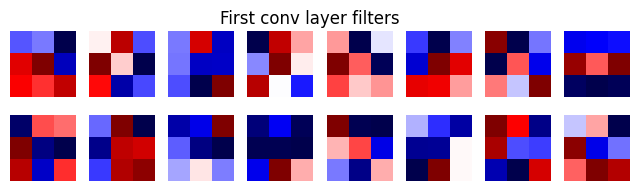

In [11]:
# Visualize first conv filters
def visualize_conv_filters(conv_layer, ncols=8):
    # conv_layer.weight shape: (out_channels, in_channels, kH, kW)
    weights = conv_layer.weight.data.clone().cpu()
    out_ch, in_ch, kH, kW = weights.shape
    # For grayscale in_ch=1, we can visualize each filter directly
    fig, axes = plt.subplots(int(np.ceil(out_ch/ncols)), ncols, figsize=(ncols, out_ch//ncols))
    axes = np.array(axes).reshape(-1)
    for i in range(out_ch):
        w = weights[i,0,:,:]  # take channel 0
        ax = axes[i]
        ax.imshow(w, cmap='seismic', vmin=w.min(), vmax=w.max())
        ax.axis('off')
    plt.suptitle('First conv layer filters')
    plt.show()

visualize_conv_filters(model.conv1, ncols=8)

Feature maps shapes: [torch.Size([1, 16, 28, 28]), torch.Size([1, 32, 14, 14]), torch.Size([1, 64, 7, 7])]


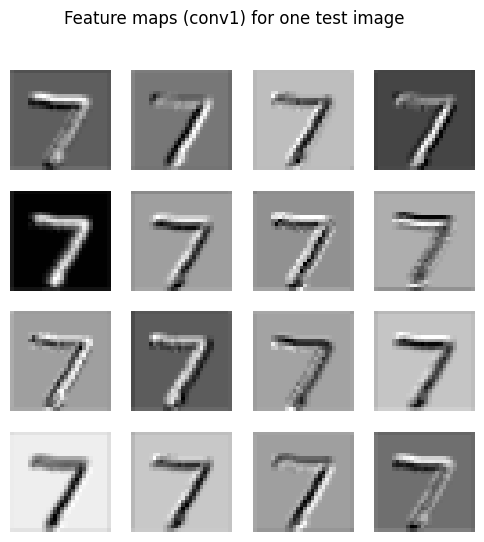

In [12]:
# Visualize feature maps for a single image
def get_feature_maps(model, x):
    feature_maps = []
    hooks = []
    def hook_fn(module, inp, out):
        if isinstance(out, torch.Tensor):
            feature_maps.append(out.detach().cpu())
    # register hooks on conv layers
    for module in [model.conv1, model.conv2, model.conv3]:
        hooks.append(module.register_forward_hook(hook_fn))
    model.eval()
    with torch.no_grad():
        _ = model(x.unsqueeze(0).to(device))
    for h in hooks:
        h.remove()
    return feature_maps

# pick a test image
img, lbl = test_set[0]
fmaps = get_feature_maps(model, img)
print('Feature maps shapes:', [fm.shape for fm in fmaps])

# plot first layer feature maps (first 16)
maps = fmaps[0][0]  # batch idx 0, shape (out_ch, H, W)
nplots = min(16, maps.shape[0])
fig, axes = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axes.flat[:nplots]):
    ax.imshow(maps[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Feature maps (conv1) for one test image')
plt.show()